# CartPole using Deep Q-Network (DQN)

This notebook implements a Deep Q-Network (DQN) to solve the CartPole-v1 environment using PyTorch and OpenAI Gym.

In [ ]:
!pip install numpy==1.23.5 --quiet
import os
os.kill(os.getpid(), 9)  # Restart the runtime after downgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires nump

In [ ]:
!pip install numpy==1.26.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [4]:
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n

        self.q_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()
        self.buffer = ReplayBuffer(10000)

        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.tau = 0.01

    def act(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return self.q_network(state).argmax().item()

    def update(self):
      if len(self.buffer) < self.batch_size:
        return

      states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

    # Forward pass on current states
      q_pred = self.q_network(states)  # shape: [batch_size, action_dim]

    # Make sure actions tensor is of shape [batch_size, 1]
      actions = actions.view(-1, 1)

    # Gather Q-values for the actions taken
      q_values = q_pred.gather(1, actions).squeeze(1)  # shape: [batch_size]

    # Forward pass on next states using target network
      with torch.no_grad():
          q_next = self.target_network(next_states).max(1)[0]
          q_target = rewards + self.gamma * q_next * (1 - dones)

    # Loss and backprop
      loss = self.criterion(q_values, q_target)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    # Update target network
      self.soft_update(self.q_network, self.target_network, self.tau)


    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

    def train(self, episodes):
        rewards = []
        for ep in range(episodes):
            state = self.env.reset()
            if isinstance(state, tuple):  # For Gym >= 0.26
                state = state[0]
            total_reward = 0
            done = False

            while not done:
                action = self.act(state)
                result = self.env.step(action)

                if len(result) == 5:  # New Gym API
                    next_state, reward, terminated, truncated, _ = result
                    done = terminated or truncated
                else:
                    next_state, reward, done, _ = result

                self.buffer.push(state, action, reward, next_state, float(done))
                self.update()
                state = next_state
                total_reward += reward

            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            rewards.append(total_reward)

            if (ep + 1) % 10 == 0:
                print(f"Episode {ep+1}, Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")

        return rewards


In [5]:
import random
from collections import deque
import numpy as np
import torch

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


In [6]:
env = gym.make("CartPole-v1", render_mode="human", new_step_api=True)
agent = DQNAgent(env)

In [7]:
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_


In [8]:
training_rewards = agent.train(episodes=100)
print("Average reward over last 10 episodes:", np.mean(training_rewards[-10:]))

Episode 10, Reward: 10.0, Epsilon: 0.95
Episode 20, Reward: 17.0, Epsilon: 0.90
Episode 30, Reward: 44.0, Epsilon: 0.86
Episode 40, Reward: 27.0, Epsilon: 0.82
Episode 50, Reward: 33.0, Epsilon: 0.78
Episode 60, Reward: 39.0, Epsilon: 0.74
Episode 70, Reward: 108.0, Epsilon: 0.70
Episode 80, Reward: 138.0, Epsilon: 0.67
Episode 90, Reward: 25.0, Epsilon: 0.64
Episode 100, Reward: 15.0, Epsilon: 0.61
Average reward over last 10 episodes: 63.1


In [9]:
training_rewards = agent.train(episodes=250)


Episode 10, Reward: 44.0, Epsilon: 0.58
Episode 20, Reward: 46.0, Epsilon: 0.55
Episode 30, Reward: 28.0, Epsilon: 0.52
Episode 40, Reward: 124.0, Epsilon: 0.50
Episode 50, Reward: 129.0, Epsilon: 0.47
Episode 60, Reward: 129.0, Epsilon: 0.45
Episode 70, Reward: 156.0, Epsilon: 0.43
Episode 80, Reward: 63.0, Epsilon: 0.41
Episode 90, Reward: 106.0, Epsilon: 0.39
Episode 100, Reward: 15.0, Epsilon: 0.37
Episode 110, Reward: 267.0, Epsilon: 0.35
Episode 120, Reward: 211.0, Epsilon: 0.33
Episode 130, Reward: 112.0, Epsilon: 0.32
Episode 140, Reward: 113.0, Epsilon: 0.30
Episode 150, Reward: 101.0, Epsilon: 0.29
Episode 160, Reward: 20.0, Epsilon: 0.27
Episode 170, Reward: 115.0, Epsilon: 0.26
Episode 180, Reward: 100.0, Epsilon: 0.25
Episode 190, Reward: 18.0, Epsilon: 0.23
Episode 200, Reward: 117.0, Epsilon: 0.22
Episode 210, Reward: 247.0, Epsilon: 0.21
Episode 220, Reward: 154.0, Epsilon: 0.20
Episode 230, Reward: 500.0, Epsilon: 0.19
Episode 240, Reward: 391.0, Epsilon: 0.18
Episode 

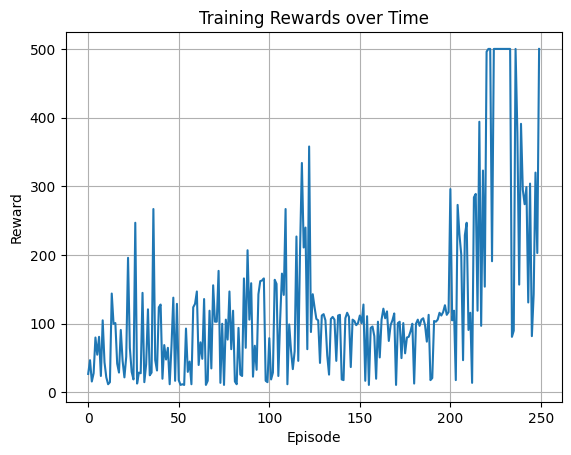

In [10]:
import matplotlib.pyplot as plt

plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Rewards over Time")
plt.grid()
plt.show()


In [18]:
torch.save(agent.q_network.state_dict(), "/content/dqn_cartpole.pth")



In [19]:
agent.q_network.load_state_dict(torch.load("dqn_cartpole.pth"))
agent.q_network.eval()

QNetwork(
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [20]:
import os
print(os.getcwd())

/content


In [21]:
import os
assert os.path.exists("/content/dqn_cartpole.pth"), "Model file not found!"


In [22]:
import gym
import torch
import numpy as np
from torch import nn
import time

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the same QNetwork you used for training
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Load the environment with rendering enabled
env = gym.make("CartPole-v1", render_mode="human")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Load the trained model
q_network = QNetwork(state_dim, action_dim).to(device)
q_network.load_state_dict(torch.load("/content/dqn_cartpole.pth", map_location=device))
q_network.eval()

# Play a few episodes
num_episodes = 5

for episode in range(1, num_episodes + 1):
    # Handle different versions of Gym's reset API
    reset_result = env.reset()
    state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

    done = False
    total_reward = 0

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

        with torch.no_grad():
            q_values = q_network(state_tensor)
            action = torch.argmax(q_values, dim=1).item()

        # Handle both step API versions
        step_result = env.step(action)
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, _ = step_result

        state = next_state
        total_reward += reward

        time.sleep(0.02)  # Slow down rendering so you can watch

    print(f"Episode {episode} — Total Reward: {total_reward}")

env.close()


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1 — Total Reward: 500.0
Episode 2 — Total Reward: 500.0
Episode 3 — Total Reward: 500.0
Episode 4 — Total Reward: 500.0
Episode 5 — Total Reward: 500.0


In [28]:
import gym
import torch
import numpy as np
from torch import nn
import os
import time
from IPython.display import HTML
from base64 import b64encode
import glob

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Q-Network Definition
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Create video folder
video_folder = "/content/videos"
os.makedirs(video_folder, exist_ok=True)

# Create environment with recording
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda ep: True)

# Get dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Load trained model
model_path = "/content/dqn_cartpole.pth"  # ✅ Make sure this path is correct
q_network = QNetwork(state_dim, action_dim).to(device)
q_network.load_state_dict(torch.load(model_path, map_location=device))
q_network.eval()

# Run one test episode
reset_out = env.reset()
state = reset_out[0] if isinstance(reset_out, tuple) else reset_out

done = False
total_reward = 0

while not done:
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

    with torch.no_grad():
        q_values = q_network(state_tensor)
        action = torch.argmax(q_values, dim=1).item()

    result = env.step(action)
    if len(result) == 5:
        next_state, reward, terminated, truncated, _ = result
        done = terminated or truncated
    else:
        next_state, reward, done, _ = result

    state = next_state
    total_reward += reward
    time.sleep(0.02)  # optional visual delay

env.close()
print(f"✅ Episode Finished | Total Reward: {total_reward}")

# Display the recorded video
video_list = sorted(glob.glob(f"{video_folder}/*.mp4"), key=os.path.getmtime)
if video_list:
    latest_video = video_list[-1]
    mp4 = open(latest_video, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML(f"""<video width=480 controls><source src="{data_url}" type="video/mp4"></video>"""))
else:
    print("❌ No video found.")


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


✅ Episode Finished | Total Reward: 500.0
